## Comparison of the Russian Five-Act Comedies in Verse With Other Traditions

In this analysis, we will compare the Russian five-act comedy in verse with the French five-act comedy in verse as well as Shakespeare and Goldoni's five-act comedies in verse. 

We will compare the mean values of each feature. For the French tradition, we will rely on the periodization that we introduced in our previous analyses. However, we will need to split Period Two into two to be able to compare the French tradition with the contemporaneous Russian tradition:
- Period One: from 1629 to 1695
- Period Two First Part: from 1696 to 1774
- Period Two Second Part: from 1775 to 1795.
- Period Three: from 1796 to 1849.

For the Russian tradition, we were unable to distinguish periods that would have significanltly different distribution of the examined features. However, for comparison with the French tradition, we will assume "tentative" periods:
- Tentative Period One: 1775 to 1795
- Tentative Period Two: 1796 to 1849.

For Shakespeare, we will use the mean values of the features for his entire corpus of the five-act comedies in verse. For Goldoni, we will use the mean values of the features for the stratified 30% random sample of his comedies. 

The sampling is described in this notebook: https://github.com/innawendell/European_Comedy/blob/master/Analyses/Goldoni_Sample.ipynb. 

We will compare Goldoni with the contemporaneous French comedies and Russian comedies of the tentative Period One and Two since there were no Russian comedies written during the time when Goldoni was active.

1. The comparison will be based on the following features:
    - The number of dramatic characters;
    - The mobility coefficient;
    - The standard range of the number of speaking characters (sigma);
    - The percentage of non-dialogues;
    - The percentage of polylogues;
    - The percentage of monologues;
    - The coefficient of unused dramatic characters;
    - The percentage of discontinuous scenes;
    - The speech distribution.
2. Run a Principal Component Analysis to reduce the number of dimensions. Visualize and analyze the results.
3. We will produce open-form scores for each tradition by decade. These open-form scores will allow us to compare different traditions in terms of being more or less experimental.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
import json
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

In [2]:
# update the boundaries as we determined based on our hypothesis testing
def determine_period(row):
    if row <= 1695:
        period = '1'
    elif row >= 1696 and row <= 1774:
        period = '2_a'
    elif row >= 1775 and row <= 1795:
        period = '2_b'
    else:
        period = '3'
    
    return period

In [3]:
def make_list(row):
    speech_dist = []
    for value in row[1:-1].split('\n '):
        speech_dist.append([int(num) for num in re.findall('[0-9]+', value)])
        
    return speech_dist

In [4]:
def speech_distribution_by_period(period_df):
    all_distributions = []
    for row in period_df['speech_distribution']:
        speech_dist_df = pd.DataFrame(row).T
        # rename columns to make sure they start with 1 and not 0
        speech_dist_df.columns = speech_dist_df.iloc[0, :]
        # no need to include the variants as a row - they will be column names
        only_counts_df = pd.DataFrame(speech_dist_df.iloc[1, :])
        only_counts_df.columns = ['raw_numbers']
        only_counts_df['percentage'] = only_counts_df['raw_numbers'] / only_counts_df.sum().values[0]
        all_distributions.append(round(only_counts_df['percentage'], 4))
        
    period_df_dist = pd.concat(all_distributions, axis=1).fillna(0)
    # take the mean for each period
    mean_per_type = pd.DataFrame(period_df_dist.mean(axis=1)).T 
    mean_per_type = (mean_per_type * 100).round(2)
    mean_per_type.index = ['percentage_of_scenes']
    mean_per_type.index.name = 'number_of_speakers'
    
    return mean_per_type

In [5]:
def sigma_iarkho(variants, weights):
    """
    The function allows calculating standard range following iarkho's procedure.
    Parameters:
        variants - a list with distinct variants in the ascending order, e.g. [1, 2, 3, 4, 5]
        weights - a list of weights corresponding to these variants, e.g. [20, 32, 18, 9, 1]
    Returns:
        sigma - standard range per iarkho
    """
    weighted_mean_variants = np.average(variants, weights=weights)
    differences_squared = [(variant - weighted_mean_variants)**2 for variant in variants]
    weighted_mean_difference = np.average(differences_squared, weights=weights)
    sigma = weighted_mean_difference**0.5

    return sigma

In [6]:
def coefficient_unused_dramatic_characters(data):
    total_present = 0
    total_non_speakers = 0
    for act in data['play_summary'].keys():
        for scene in data['play_summary'][act].keys():
            # identify the raw number of non-speaking dramatic characters
            num_non_speakers = len([item for item in data['play_summary'][act][scene].items() 
                                if (item[1] == 0  or item[1] == 'non_speaking') and item[0] not in ['num_utterances',
                                                                   'num_speakers',
                                                                   'perc_non_speakers']])
            total_non_speakers += num_non_speakers
            # calculate the total number of dramatic characters
            total_present += (data['play_summary'][act][scene]['num_speakers'] + num_non_speakers)
    coefficient_unused = (total_non_speakers / total_present ) * 100        
    
    return coefficient_unused

In [7]:
def get_data(input_directory):
    all_files = [f for f in listdir(input_directory) if f.count('.json') > 0]
    dfs = []
    for file in all_files:
        with open(input_directory + '/' + file) as json_file:
            data = json.load(json_file)
            not_used = coefficient_unused_dramatic_characters(data)
            df = pd.DataFrame([not_used], columns=['coefficient_unused'], index=[file.replace('.json','')])
            dfs.append(df)
            
    features_df = pd.concat(dfs, axis=0, sort=False).round(2)
    
    return features_df

In [8]:
def plot_speech_distribution(speech_dist_df, title):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=14)
    sns.barplot(x=speech_dist_df.columns.tolist(), 
                y=speech_dist_df.values.tolist()[0])
    plt.xlabel('Number of Speakers', fontsize=12)
    plt.ylabel('Percentage of Scenes', fontsize=12)

    plt.show()

In [9]:
def interval_data(data_df, feature, other_tradition_df=None):
    if other_tradition_df is not None:
        overall_mean = round(other_tradition_df[feature].mean(), 2)
        overall_std = round(other_tradition_df[feature].std(), 2)
    else:
        overall_mean = round(data_df[feature].mean(), 2)
        overall_std = round(data_df[feature].std(), 2)
    
    statistics = ['mean'] 
    all_data = pd.DataFrame(data_df.groupby(['decades'])[feature].mean())
    all_data.columns= ['mean']
    all_data['z_score'] = (all_data['mean'] - overall_mean) / overall_std
    
    return  all_data

In [10]:
def scores_calculation(df, with_z_score=True, other_tradition_df=None):
    if with_z_score:
        column = 'z_score'
        sigma_col = column
    else:
        column = ['mean']
        sigma_col = 'sigma_iarkho'       
    summary = pd.DataFrame(interval_data(df, 'num_present_characters', other_tradition_df)[column])
    summary.columns = ['num_present_characters']
    # make sure the order of the playwrights is the same
    
    ind = summary.index
    summary['mobility_coefficient'] = interval_data(df, 'mobility_coefficient', 
                                                   other_tradition_df).loc[ind, column]
    summary['sigma_iarkho'] = interval_data(df, 'sigma_iarkho', 
                                           other_tradition_df).loc[ind, column]
    summary['polylogues'] = interval_data(df, 'percentage_polylogues', 
                                          other_tradition_df).loc[ind, column]
    summary['monologues'] = interval_data(df, 'percentage_monologues', 
                                          other_tradition_df).loc[ind, column]
    summary = summary.round(2)
    if with_z_score:
        summary['monologues'] = summary['monologues'].apply(lambda x: -x)
        summary['open_form_score'] = round(summary.apply(lambda x: x.mean(), axis=1), 2)
        summary = summary.sort_values(by='open_form_score', ascending=False)
  
    return summary

In [11]:
def report(dictionary):
    dictionary = dict(sorted(dictionary.items(), key=lambda item: np.abs(item[1])))
    for item in dictionary.items():
        print('\t' + item[0] + ':', item[1])
    print('\n')       

In [12]:
def decade(n):
    return (n + (10 - n) % 10) - 10

### Part 1. Comparison of The French and Russian Five-Act Comedy in Verse

### Load and Process The French Data

In [13]:
# read the data
french_data = pd.read_csv('../French_Comedies/Data/French_Comedies_Data.csv')

# include only five act comedies and only the comedies that are not translations/adaptations 
french_original_comedies = french_data[(french_data['num_acts'] ==5)&
                               (french_data['translation/adaptation/contrastive'] == 0)].copy()

# rename column names for clarity
french_original_comedies = french_original_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                  'percentage_above_two_speakers': 'percentage_polylogues',
                                                 'percentage_scenes_with_discontinuous_change_characters': 'discontinuous_scenes'})
# read the sample data
french_sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')


# exclude the comedies used for the sample analysis
not_sample = french_original_comedies[~french_original_comedies['index'].isin(french_sample_df['index'])].copy()

# sort by date
french_sorted_comedies = not_sample.sort_values(by='date')

# identify decades
french_sorted_comedies['decades'] = french_sorted_comedies['date'].apply(decade)

In [14]:
features = ['num_present_characters',
            'mobility_coefficient', 
            'standard_range', 
            'percentage_non_dialogues',
            'percentage_polylogues',
            'percentage_monologues',
             'coefficient_unused',
             'discontinuous_scenes']

In [15]:
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../French_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
french_sorted_comedies = french_sorted_comedies.merge(unused_coefficient, on='index')

In [16]:
french_sorted_comedies['period'] = french_sorted_comedies.date.apply(determine_period)

#### Exploration of The Scenes with No Speakers 

Upon close examination of our data, we discovered that some comedies had scenes with no speakers. We decided to investigate this issue. 

Scenes with no Speakers in Period One:
- N.Gillet de la Tessonnerie's *Le Campagnard* (1657) has a scene with no speakers (act 5 scene 1)
- Marcel's *Le Mariage sans mariage* (1671) has two errors in the markup (act 5 scene 3.1 extra - Gusman is speaking, marked as non-speaking; in act 5 scene 6.1 extra is an erroneously distinguished scene with no speaking characters).
- Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674) has a scene with no speaking characters (act 1 scene 11).

Scenes With No Speakers in Period Two (first part):
- Bouy and Fétiq's comedy *La Famille ridicule, comédie messine* (1720) has an error in the markup (act 4 scene 9, Ourselle is speaking).

Scenes With No Speakers in Period Two (second part):
- Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784) act 5 scene 5 has no speakers.

Scenes With No Speakers in Period Three:
- Ancien militaire's *L'Ami de cour* (1801) has an error in the markup (in act 3 scene 9 Floriman is speaking).
- Th. Princeteau's *Constance ou l'indifférence vaincue* (1824) has an error in the markup (in act 1 has an incorrectly identified scene 5.1 extra with no speakers).

This brief investigation showed that there were three comedies, N.Gillet de la Tessonnerie's *Le Campagnard* (1657), Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674), Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784), that indeed had scenes no speaking dramatic characters. Other comedies, Marcel's *Le Mariage sans mariage* (1671), Bouy and Fétiq's comedy *La Famille ridicule, comédie messine* (1720), Ancien militaire's *L'Ami de cour* (1801), and Th. Princeteau's *Constance ou l'indifférence vaincue* (1824) have errors in the markup. We addressed this issue by correcting the speech distribution in these comedies.

In [17]:
# correct speech distribution where we identified errors in the markup
french_sorted_comedies.loc[64, 'speech_distribution'] = '[[1, 8], [2, 14], [3, 10], [4, 1], [5, 1], [6, 2]]'
french_sorted_comedies.loc[97, 'speech_distribution'] = '[[1, 9], [2, 33], [3, 6], [4, 2]])'
french_sorted_comedies.loc[178, 'speech_distribution'] = '[[1, 19], [2, 22], [3, 5], [4, 5], [5, 1]]'
french_sorted_comedies.loc[208, 'speech_distribution'] = '[[1, 10], [2, 19], [3, 7], [4, 4], [5, 2], [7, 1], [8, 2]]'

french_sorted_comedies['speech_distribution'] = french_sorted_comedies['speech_distribution'].apply(make_list)

In [18]:
french_feature_one = french_sorted_comedies.groupby('period').describe().loc[:, 'num_present_characters'][['mean']]
french_feature_two = french_sorted_comedies.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean']]
french_feature_three = french_sorted_comedies.groupby('period').describe().loc[:, 'sigma_iarkho'][['mean']]
french_feature_four = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean']]
french_feature_five = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean']]
french_feature_six = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_monologues'][['mean']]
french_feature_seven = french_sorted_comedies.groupby('period').describe().loc[:, 'coefficient_unused'][['mean']]
french_feature_eight = french_sorted_comedies.groupby('period').describe().loc[:, 'discontinuous_scenes'][['mean']]

french_summary_comedies = pd.concat([french_feature_one, 
                              french_feature_two, 
                              french_feature_three, 
                              french_feature_four, 
                              french_feature_five, 
                              french_feature_six,
                              french_feature_seven,
                              french_feature_eight], axis=1)
french_summary_comedies.columns = features
french_summary_comedies = french_summary_comedies.T
french_summary_comedies.columns = ['Period One: 1629 to 1695', 
                                   'Period Two First Part: 1696 to 1774',
                                   'Period Two Second Part: 1775 to 1795',
                                   'Period Three: 1796 to 1849'
                                  ]
french_summary_comedies = french_summary_comedies.round(2)

In [19]:
french_period_one = french_sorted_comedies[french_sorted_comedies.period == '1'].copy()
french_period_two_first_part = french_sorted_comedies[french_sorted_comedies.period == '2_a'].copy()
french_period_two_second_part = french_sorted_comedies[french_sorted_comedies.period == '2_b'].copy()
french_period_three = french_sorted_comedies[french_sorted_comedies.period == '3'].copy()

### Load and Process Russian Data

In [20]:
# updated boundaries
def determine_period_russian(row):
    if row <= 1795:
        period = 1
    else:
        period = 2
    
    return period

In [21]:
russian_comedies = pd.read_csv('../Russian_Comedies/Data/Comedies_Raw_Data.csv')
# sort by creation date
russian_comedies_sorted = russian_comedies.sort_values(by='creation_date').copy()

# select only original comedies and five act
russian_original_comedies = russian_comedies_sorted[(russian_comedies_sorted['translation/adaptation'] == 0) & 
                                   (russian_comedies_sorted['num_acts'] == 5)].copy()
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../Russian_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
russian_comedies_df = russian_original_comedies.merge(unused_coefficient, on='index')

In [22]:
russian_comedies_df['period'] = russian_comedies_df['creation_date'].apply(determine_period_russian)
russian_comedies_df['speech_distribution'] = russian_comedies_df['speech_distribution'].apply(make_list)
# rename column names for clarity
russian_comedies_df = russian_comedies_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                 'percentage_above_two_speakers': 'percentage_polylogues',
                                                 'percentage_scenes_with_discontinuous_change_characters': 'discontinuous_scenes',
                                                 'sigma_iarkho': 'standard_range'})
russian_comedies_df['decades'] = russian_comedies_df.creation_date.apply(decade)

In [23]:
russian_period_one = russian_comedies_df[russian_comedies_df.period == 1].copy()
russian_period_two = russian_comedies_df[russian_comedies_df.period == 2].copy()

In [24]:
russian_feature_one = russian_comedies_df.groupby('period').describe().loc[:, 'num_present_characters'][['mean']]
russian_feature_two = russian_comedies_df.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean']]
russian_feature_three = russian_comedies_df.groupby('period').describe().loc[:, 'standard_range'][['mean']]
russian_feature_four = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean']]
russian_feature_five = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean']]
russian_feature_six = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_monologues'][['mean']]
russian_feature_seven = russian_comedies_df.groupby('period').describe().loc[:, 'coefficient_unused'][['mean']]
russian_feature_eight = russian_comedies_df.groupby('period').describe().loc[:, 'discontinuous_scenes'][['mean']]

russian_summary_comedies = pd.concat([russian_feature_one, 
                              russian_feature_two, 
                              russian_feature_three, 
                              russian_feature_four, 
                              russian_feature_five, 
                              russian_feature_six,
                              russian_feature_seven,
                              russian_feature_eight], axis=1)
russian_summary_comedies.columns = features
russian_summary_comedies = russian_summary_comedies.T
russian_summary_comedies.columns = ['tentative Period One: 1775 to 1795', 
                                    'tentative Period Two: 1796 to 1849']
russian_summary_comedies = russian_summary_comedies.round(2)

### French Comedies Five-Act Comedies in Verse

In [25]:
french_summary_comedies.iloc[:, 2:]

,Period Two Second Part: 1775 to 1795,Period Three: 1796 to 1849
num_present_characters,11.27,11.96
mobility_coefficient,51.79,54.31
standard_range,1.14,1.33
percentage_non_dialogues,53.73,58.12
percentage_polylogues,29.80,37.69
percentage_monologues,23.87,20.35
coefficient_unused,14.01,13.74
discontinuous_scenes,7.55,5.83


### Russian Comedies Five-Act Comedies in Verse

In [26]:
russian_summary_comedies

,tentative Period One: 1775 to 1795,tentative Period Two: 1796 to 1849
num_present_characters,11.50,14.70
mobility_coefficient,53.17,61.60
standard_range,1.48,1.54
percentage_non_dialogues,59.94,60.64
percentage_polylogues,38.11,39.68
percentage_monologues,21.84,20.65
coefficient_unused,19.04,21.40
discontinuous_scenes,6.05,6.55


### Summary:
#### The Russian tentative Period One (1775 to 1795) vs. the second part of the French Period Two (1775 to 1795):
1. In the Russian tentative Period One (1775 to 1794), most of the mean values of the features were higher than the those in the second part of the French Period Two (1775 to 1795):
    - The number of dramatic characters (11.50 in Russian vs. 11.27 in French);
    - The mobility coefficient (53.17 in Russian vs. 51.79 in French);
    - The standard range (1.48 in Russian vs. 1.14 in French);
    - The percentage of non-dialogues (59.94% vs. 53.73%);
    - The percentage of polylogues (38.11% vs. 29.80%).
    - The coefficient of unused dramatic characters (19.04% vs. 14.01%).
2. In the case of two features, the mean percentage of monologues and the percentage of discontinuous scenes, the Russian comedies had lower mean values than the French ones:
    - The percentage of monologues (21.84% in Russian vs. 23.87% in French);
    - The percentage of discontinuous scenes (6.05% in Russian vs. 7.55% in French).
    
#### The Russian tentative Period Two (1795 - 1849) vs. the French Period Three (1796 to 1849):
1. In the Russian tentative Period Two, all of the examined features had higher mean values than those in the French Period Three:
    - The number of dramatic characters (14.70 in Russian vs. 11.96 in French);
    - The mobility coefficient (61.60 vs. 54.31);
    - The standard range (1.54 vs. 1.33);
    - The percentage of non-dialogues (60.64% vs. 58.12%);
    - The percentage of polylogues (39.68% vs. 37.69%);
    - The percentage of monologues (20.65% vs. 20.35%);
    - The coefficient of unused dramatic characters (21.40 vs.13.74);
    - The percentage of discontinuous scenes (6.55% vs. 5.83%).

In [27]:
french_summary_comedies.iloc[:, :2]

,Period One: 1629 to 1695,Period Two First Part: 1696 to 1774
num_present_characters,11.81,10.28
mobility_coefficient,41.82,48.29
standard_range,1.23,1.12
percentage_non_dialogues,56.11,53.37
percentage_polylogues,42.81,32.26
percentage_monologues,13.18,21.07
coefficient_unused,12.17,12.03
discontinuous_scenes,13.37,6.49


### Comparison:
####  The Russian tentative Period One (1775 to 1795) vs. the first part of the French Period Two (1696 to 1774):
1.  The mean values of almost all features were higher in the Russian tentative Period One as compared to the first part of the French Period Two.
    - The number of dramatic characters (11.50 in Russian vs. 10.28 in French);
    - The mobility coefficient (53.17 in Russian vs. 48.29 in French);
    - The standard range (1.48 in Russian vs. 1.12 in French);
    - The percentage of non-dialogues (59.94% vs. 53.37%);
    - The percentage of polylogues (38.11% vs. 32.26%);
    - The percentage of monologues (21.84% in Russian vs. 21.07% in French);
    - The coefficient of unused dramatic characters (19.04% vs. 12.03%).
2. The mean percentage of discontinuous scenes was lower in the Russian tentative Period Two than in the first part of the French Period Two (6.05% in Russian vs.  6.49% in French).

####  The Russian tentative Period One (1775 to 1795) vs. the French Period One (1629 to 1695):
1. The mean values of some features were higher in the Russian tentative Period One as compared to the French Period One:
    - The mobility coefficient (53.17 in Russian vs. 41.82);
    - The standard range of the speaking characters (1.48 vs. 1.23);
    - The percentage of non-dialogues (59.94% vs. 56.11%);
    - The percentage of monologues (21.84% vs. 13.18%);
    - The coefficient of unused dramatic characters (19.04 vs. 12.17).
    
2. Three features had lower mean values in the Russian tentative Period One than in the French Period One:
    - The number of dramatic characters (11.50 in Russian vs. 11.81 in the French);
    - The percentage of monologues (21.84% in the Russian vs. 13.18% in the French);
    - The percentage of discontinuous scenes (6.05% in the Russian vs. 13.37% in the French);

### Speech Distribution in the French Five-Act Comedy In Verse in Period One

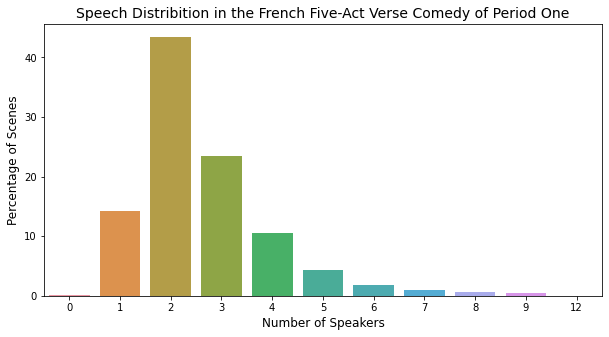

In [28]:
plot_speech_distribution(speech_distribution_by_period(french_period_one), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period One')

In [29]:
speech_distribution_by_period(french_period_one)

,0,1,2,3,4,5,6,7,8,9,12
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.06,14.16,43.43,23.42,10.6,4.39,1.86,0.91,0.68,0.48,0.01


N.Gillet de la Tessonnerie's *Le Campagnard* (1657) and Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674) have scenes with no speakers.

In [30]:
np.sum(speech_distribution_by_period(french_period_one).values[0][7:])

2.08

### Speech Distribution in the French Five-Act Comedy In Verse in Period Two (First Part)

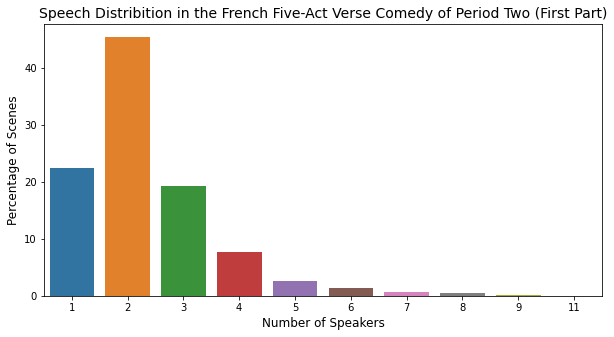

In [31]:
plot_speech_distribution(speech_distribution_by_period(french_period_two_first_part), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Two (First Part)')

In [32]:
speech_distribution_by_period(french_period_two_first_part)

,1,2,3,4,5,6,7,8,9,11
number_of_speakers,,,,,,,,,,
percentage_of_scenes,22.52,45.49,19.32,7.63,2.64,1.3,0.59,0.41,0.08,0.03


In [33]:
np.sum(speech_distribution_by_period(french_period_two_first_part).values[0][6:])

1.11

### Speech Distribution in the French Five-Act Comedy In Verse in Period Two (Second Part)

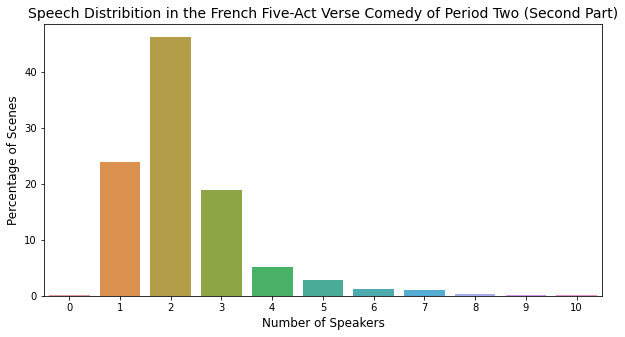

In [34]:
plot_speech_distribution(speech_distribution_by_period(french_period_two_second_part), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Two (Second Part)')

In [35]:
speech_distribution_by_period(french_period_two_second_part)

,0,1,2,3,4,5,6,7,8,9,10
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.06,23.87,46.27,18.92,5.15,2.84,1.3,1.0,0.35,0.19,0.06


In [36]:
np.sum(speech_distribution_by_period(french_period_two_second_part).values[0][7:])

1.6

Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784) has a scene with no speakers.

### Speech Distribution in the French Five-Act Comedy In Verse in Period Three

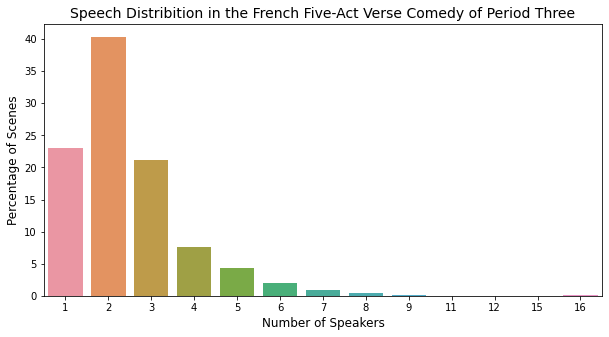

In [37]:
plot_speech_distribution(speech_distribution_by_period(french_period_three), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Three')

In [38]:
speech_distribution_by_period(french_period_three)

,1,2,3,4,5,6,7,8,9,11,12,15,16
number_of_speakers,,,,,,,,,,,,,
percentage_of_scenes,23.01,40.33,21.09,7.59,4.31,1.96,0.88,0.5,0.18,0.04,0.04,0.02,0.05


In [39]:
np.sum(speech_distribution_by_period(french_period_three).values[0][6:])

1.71

### Speech Distribution in the Russian Five-Act Comedy In Verse in The Tentative Period One

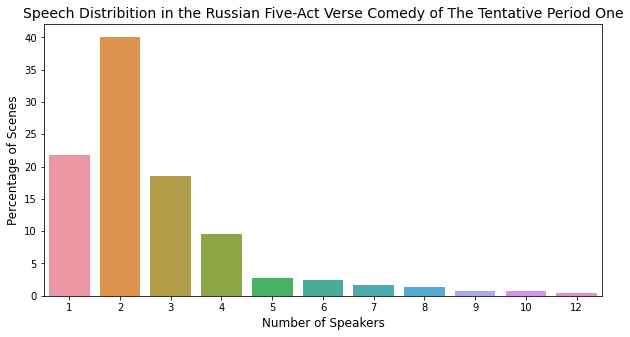

In [40]:
plot_speech_distribution(speech_distribution_by_period(russian_period_one), 
                         'Speech Distribition in the Russian Five-Act Verse Comedy of The Tentative Period One')

In [41]:
speech_distribution_by_period(russian_period_one)

,1,2,3,4,5,6,7,8,9,10,12
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,21.84,40.06,18.58,9.53,2.79,2.44,1.7,1.29,0.71,0.71,0.36


In [42]:
round(np.sum(speech_distribution_by_period(russian_period_one).values[0][6:]), 2)

4.77

### Speech Distribution in the Russian Five-Act Comedy In Verse in The Tentative Period Two

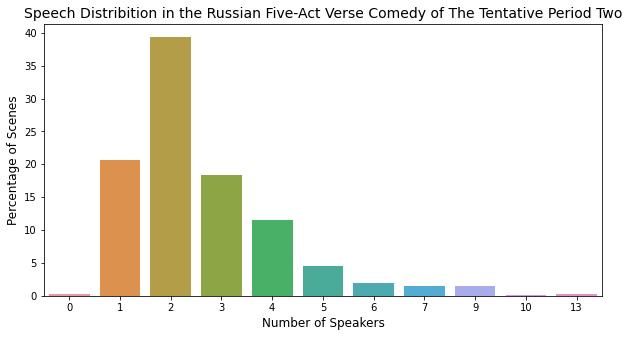

In [43]:
plot_speech_distribution(speech_distribution_by_period(russian_period_two), 
                         'Speech Distribition in the Russian Five-Act Verse Comedy of The Tentative Period Two')

Note that in the Russian corpus there is a comedy that has zero speakers in a scene, Boris Fedorov's *Chudnya vstrechi* (1818).

In [44]:
speech_distribution_by_period(russian_period_two)

,0,1,2,3,4,5,6,7,9,10,13
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.3,20.66,39.36,18.39,11.45,4.58,1.99,1.42,1.45,0.17,0.22


In [45]:
round(np.sum(speech_distribution_by_period(russian_period_two).values[0][7:]), 2)

3.26

### Summary:

#### Comparison of The Speech Distribution in the Russian tentative Period One and the French Period Two (second part):
the maximum number of speaking characters in the tentative Russian Period One was 12 while 4.77% had above six speakers. In the French Period Two (second part), the maximum number of speakers was 10, with 1.6% of the scenes having over six speakers. In the French Period Two (second part, there was a comedy with a scene that had no speakers - Marc-Antoine-Jacques Rochon de Chabannes’s *Le Jaloux* (1784). In the tentative Russian Period One, there were no such comedies


#### Comparison of The Speech Distribution in the Russian tentative Period Two and the French Period Three:
in the tentative Russian Period Two, the maximum number of speakers was 13, with 3.26% of the scenes having over six speakers. In the French Period Three, the maximum number of speakers was 16, with 1.71% of the scenes having over six speakers. In the tentative Russian Period Two, there was one comedy with a scene without any speakers (Boris Fedorov’s *Chudnya vstrechi* (1818)). In the French Period Three, there were no such comedies.

### Additional Comparisons:

#### Comparison of The Speech Distribution in the Russian tentative Period One and the French Period Two (first part):
The maximum number of speaking characters in the Russian tentative Period One was 12; 4.77% had above six speakers.  In the French Period Two (first part), the maximum number of speakers was 11, with 1.11% having over six speakers. Neither Russian nor French comedies of the above mentioned periods had scenes without speakers.

#### Comparison of The Speech Distribution in the Russian tentative Period One and the French Period One:
The maximum number of speaking characters in the Russian tentative Period One was 12; 4.77% had above six speakers. In the French Period One, the maximum number of speakers was also 12. However, only 2.08% of the scenes had over six speakers. In the French Periods One, two comedies had scenes without any speakers, N.Gillet de la Tessonnerie's Le Campagnard (1657) and Noël Lebreton, sieur de Hauteroche's Crispin musicien (1674). In the tentative Russian Period One, there were no such comedies.


### Contrastive Material

#### Load Contrastive Material Data

In [46]:
contr_data_df = pd.read_csv('../Contrastive_Material/Contrastive_Material_Data.csv')
contr_data_df['speech_distribution'] = contr_data_df['speech_distribution'].apply(make_list)
# sort by date
sorted_contr_data_df = contr_data_df.sort_values(by='date')

sorted_contr_data_df  = sorted_contr_data_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                           'percentage_non_duologues': 'percentage_non_dialogues',
                                                           'percentage_above_two_speakers': 'percentage_polylogues',
                                                            'percentage_scenes_with_discontinuous_change_characters': 
                                                            'discontinuous_scenes',
                                                            'sigma_iarkho': 'standard_range'})
sorted_contr_data_df['date'] = sorted_contr_data_df['date'].astype('int')
sorted_contr_data_df['last_name'] = sorted_contr_data_df['last_name'].str.strip()

shakespeare_df = sorted_contr_data_df[sorted_contr_data_df.last_name == 'Shakespeare'].copy()
goldoni_df = sorted_contr_data_df[sorted_contr_data_df.last_name == 'Goldoni'].copy()

### William Shakespeare (1582 - 1616)

In [47]:
shakespeare_summary = pd.DataFrame(shakespeare_df.describe().loc['mean', features]).round(2)
shakespeare_summary.columns = ['Shakespeare']

In [48]:
shakespeare_summary

,Shakespeare
num_present_characters,25.83
mobility_coefficient,78.00
standard_range,1.33
percentage_non_dialogues,61.76
percentage_polylogues,37.85
percentage_monologues,23.56
coefficient_unused,40.99
discontinuous_scenes,19.35


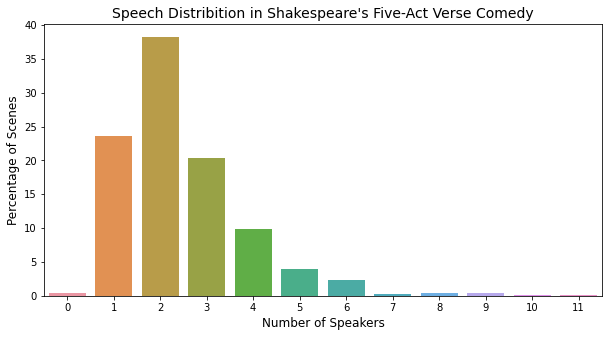

In [49]:
plot_speech_distribution(speech_distribution_by_period(shakespeare_df), 
                         'Speech Distribition in Shakespeare\'s Five-Act Verse Comedy')

### Shakespeare in The Context of Other Traditions:
1. The mean number of dramatic characters in Shakespeare's five-act verse comedies (25.83) was the highest observed in our material (French, Russian, and Contrastive).
2. The mean mobility coefficient in Shakespeare's comedies was the highest in our material (78).
3. The mean percentage of non-dialogues in Shakespeare's comedies was the highest observed (61.76%).
4. The mean percentage of monologues was also the highest in our material (23.56%).
5. The mean coefficient of unused dramatic characters is the highest observed (40.99%). The second highest coefficient of unused dramatic characters (in Goldoni, 17.28 does not come even close to that of Shakespeare). There are many dramatic characters who appear on stage but do not speak.
6. The mean percentage of discontinuous scenes in Shakespeare's comedies (19.35%) was the highest in our material.
7. The mean percentage of polylogues (37.85%) was slightly higher than that in the French Period Three (37.69) and lower than that in the Russian tentative Periods One (38.11%) and Two (39.68%).
8. The standard range of the speaking characters (1.33) was the same as the standard range of the speaking characters in the French Period Three. It was lower than in the Russian tentative Periods One (1.48) and Two (1.54). 
9. The maximum number of speaking dramatic characters was 11, which was the same as the maximum number of speakers in the French comedy of Period Two (first part). In the French Period Two (second half), the maximum number of speakers was lower (10).In the French Periods One and Three, the maximum number of speakers was higher (12 and 16 respectively). In the Russian tentative Periods One and Two, the maximum number of speakers was also higher (12 and 13).
17. In Shakespeare's comedies, there were scenes with no speakers (cf. in the French comedy of Periods One and Two (second part), there were scenes with no speakers. In the Russian tentative Period Two, there was a comedy with a scene without any speakers).

### Carlo Goldoni (1707 - 1793)

In [50]:
goldoni_summary = pd.DataFrame(goldoni_df.describe().loc['mean', features]).round(2)
goldoni_summary.columns = ['Goldoni']

In [51]:
goldoni_summary

,Goldoni
num_present_characters,11.88
mobility_coefficient,62.25
standard_range,1.21
percentage_non_dialogues,58.64
percentage_polylogues,38.74
percentage_monologues,19.65
coefficient_unused,17.28
discontinuous_scenes,9.80


In [52]:
french_sorted_comedies = french_sorted_comedies.rename(columns={'sigma_iarkho': 'standard_range'}).copy()

In [53]:
french_time_limit = french_sorted_comedies[french_sorted_comedies.date.between(1751, 1759)].copy()
french_cont = pd.DataFrame(french_time_limit.describe().loc['mean', features]).round(2).copy()

In [54]:
french_cont.columns = ['French_1751_to_1759']

In [55]:
french_cont

,French_1751_to_1759
num_present_characters,11.00
mobility_coefficient,43.80
standard_range,1.23
percentage_non_dialogues,54.96
percentage_polylogues,35.71
percentage_monologues,19.25
coefficient_unused,12.69
discontinuous_scenes,3.34


### Speech Distribution in Carlo Goldoni's Five-Act Comedies in Verse

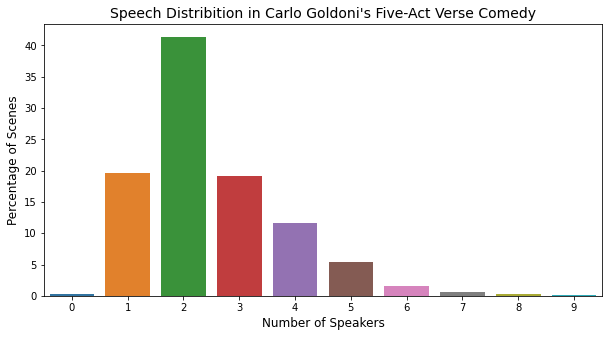

In [56]:
plot_speech_distribution(speech_distribution_by_period(goldoni_df), 
                         'Speech Distribition in Carlo Goldoni\'s Five-Act Verse Comedy')

In Goldoni's comedy I morbinosi, there is indeed a ball scene where no dramatic characters speak.

In [57]:
speech_distribution_by_period(goldoni_df)

,0,1,2,3,4,5,6,7,8,9
number_of_speakers,,,,,,,,,,
percentage_of_scenes,0.25,19.65,41.36,19.2,11.6,5.41,1.5,0.53,0.36,0.14


### French Five-Act Verse Comedies Between 1751 and 1759

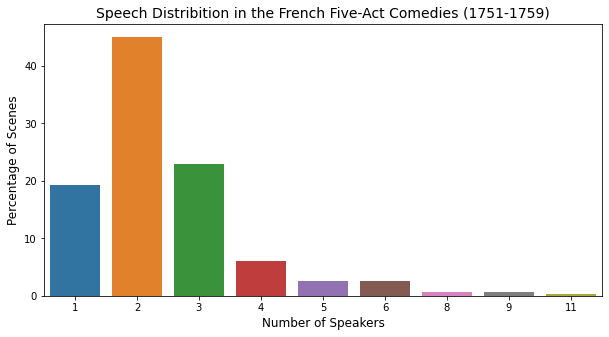

In [58]:
plot_speech_distribution(speech_distribution_by_period(french_time_limit), 
                         'Speech Distribition in the French Five-Act Comedies (1751-1759)')

In [59]:
speech_distribution_by_period(french_time_limit)

,1,2,3,4,5,6,8,9,11
number_of_speakers,,,,,,,,,
percentage_of_scenes,19.25,45.04,22.91,6.09,2.66,2.5,0.59,0.59,0.37


#### Comparison of Goldoni's Five-Act Verse Comedies with the Contemporaneous French Five-Act Comedies in Verse:
Carlo Goldoni wrote five-act verse comedies between 1751 and 1759. We will compare them with the French comedies from the same time frame.
1. Goldoni's comedies had higher mean values of the following features:
    - The mean number of dramatic characters (11.88 vs. 11 in French comedies);
    - The mobility coefficient (62.25 vs. 43.80);
    - The percentage of non-dialogues (58.64% vs. 54.96%);
    - The percentage of polylogues (38.74% vs. 35.71%).
    - The percentage of monologues (19.65% vs. 19.25%), which was only slightly higher in Goldoni;
    - The coefficient of unused dramatic characters (17.28 vs. 12.69);
    - The percentage of discontinuous scenes (9.80% vs. 3.34%).

2. Goldoni's comedies had lower mean values of the standard range of the number of speaking characters (1.21 in Goldoni vs. 1.23 in the French comedies), which was very still very close.
3. The maximum number of speakers in Goldoni's five-act comedies was nine, whereas, in the French five-act verse comedies of that time, it was 11.
3. Goldoni had a comedy with a scene without any speakers, whereas the French comedies of that period did not have such scenes.

#### Comparison of Goldoni's Five-Act Verse Comedies with the Russian Five-Act Comedies in Verse of the Tentative Period One:
1. Goldoni had higher mean values than the Russian comedies of the tentative Period One for the following features:
    - The mean number of dramatic characters (11.88 vs. 11.50 in Russian);
    - The mobility coefficient (62.25 vs. 53.17);
    - The percentage of polylogues (38.74% vs. 38.11%), which was only slightly higher;
    - The percentage of discontinuous scenes (9.8% vs. 6.05).

2. Goldoni had lower mean values than the Russian comedies of the tentative Period One for the following features:
    - The standard range of the number of speaking characters (1.21 vs. 1.48 in Russian);
    - The percentage of non-dialogues (58.64% vs. 59.94%);
    - The percentage of monologues (19.65% vs. 21.84%);
    - The coefficient of unused dramatic characters (17.28 vs. 19.04).
3. The maximum number of speakers in Goldoni was 9, whereas in the Russian comedies of the tentative Period One, it was 12.

#### Comparison of Goldoni's Five-Act Verse Comedies with the Russian Five-Act Comedies in Verse of the Tentative Period Two:
- Goldoni had lower mean values than the Russian five-act verse comedies of the tentative Period Two in all features, except for the mobility coefficient (62.25 in Goldoni vs. 61.60 in Russian comedies) and the percentage of discontinuous scenes (9.80 vs. 6.55 in Russian comedies).

- The maximum number of speakers in Goldoni was 9, whereas in the Russian comedies of the tentative Period Two, it was 13.

### Principal Component Analysis. Visualization of The Principal Components

In this section, we will reduce our eight features using a dimensionality reduction technique called Principal Component Analysis (PCA). This technique allows to reduce the number of dimensions while preserving the largest amount of variance in the data. To read more about PCA, refer to Géron Aurélen. "Dimensionality Reduction. PCA." In *Hands-On Machine Learning with Scikit-Learn & TensorFlow*, 213-223. Bejing, Boston, Farnham, Sebastopol, Tokyo: O'Reily, 2017.

We will bring the data to scale by turning each data point into a z-score (using sklearn's StandardScaler) and project our data into two dimensions so that we can visualize.

In [60]:
selected_features = ['num_present_characters',
                    'mobility_coefficient', 
                    'standard_range', 
                    'percentage_non_dialogues',
                    'percentage_polylogues',
                    'percentage_monologues',
                    'coefficient_unused',
                    'discontinuous_scenes', 
                    'title']

In [61]:
french_selection = french_sorted_comedies.loc[:, selected_features].copy()
russian_selection = russian_comedies_df.loc[:, selected_features].copy()
shakespeare_selection = shakespeare_df.loc[:, selected_features].copy()
goldoni_selection = goldoni_df.loc[:, selected_features].copy()

In [62]:
# bring the data to the same scale
scaler = StandardScaler()
french_scaled = scaler.fit_transform(french_selection.iloc[:, :-1])
russian_scaled = scaler.transform(russian_selection.iloc[:, :-1])
shakespeare_scaled = scaler.transform(shakespeare_selection.iloc[:, :-1])
goldoni_scaled = scaler.transform(goldoni_selection.iloc[:, :-1])

In [63]:
# turn rescaled data into dataframes with a column source
russian_scaled_df = pd.DataFrame(russian_scaled)
russian_scaled_df['title'] = russian_selection.iloc[:, -1]
russian_scaled_df['source'] = 'Russian'

french_scaled_df = pd.DataFrame(french_scaled)
french_scaled_df['title'] = french_selection.iloc[:, -1]
french_scaled_df['source'] = 'French'

shakespeare_scaled_df = pd.DataFrame(shakespeare_scaled)
shakespeare_scaled_df['title'] = shakespeare_selection.iloc[:, -1]
shakespeare_scaled_df['source'] = 'Shakespeare'

goldoni_scaled_df = pd.DataFrame(goldoni_scaled)
goldoni_scaled_df['title'] = goldoni_selection.iloc[:, -1].tolist()
goldoni_scaled_df['source'] = 'Goldoni'

In [64]:
# combine these dataframes into one
combined_df = pd.concat([russian_scaled_df, french_scaled_df, shakespeare_scaled_df, goldoni_scaled_df])
combined_df.columns = selected_features + ['source']

### Principal Component Analysis

In [65]:
#transform them into two dimensions
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(combined_df.iloc[:, :-2]) # exclude source and title columns

In [66]:
combined_df['PCA_Component_1'] = pca_transformed[:, 0]
combined_df['PCA_Component_2'] = pca_transformed[:, 1]

In [67]:
# investigage which features are most correlated with the first principal component
combined_df.corr()['PCA_Component_1'].round(2).sort_values(ascending=False)

PCA_Component_1             1.00
num_present_characters      0.87
coefficient_unused          0.84
mobility_coefficient        0.59
standard_range              0.49
percentage_non_dialogues    0.48
percentage_polylogues       0.36
discontinuous_scenes        0.07
PCA_Component_2             0.00
percentage_monologues      -0.07
Name: PCA_Component_1, dtype: float64

In [68]:
# investigage which features are most correlated with the second principal component
combined_df.corr()['PCA_Component_2'].round(2).sort_values(ascending=False)

PCA_Component_2             1.00
percentage_polylogues       0.88
percentage_non_dialogues    0.58
standard_range              0.56
PCA_Component_1             0.00
discontinuous_scenes       -0.02
num_present_characters     -0.12
coefficient_unused         -0.20
mobility_coefficient       -0.56
percentage_monologues      -0.72
Name: PCA_Component_2, dtype: float64

#### Principal Component 1
The first principal component mainly characterizes such features as the number of number of dramatic characters, the coefficient of unused dramatic characters, the mobility coefficient, and, to a lesser extent, the standard range and the percentage of non-dialogues. For the most part, this principal component captures information about dramatic characters, their movement, and non-utilization in dialogue. 

#### Principal Component 2
The second principal component has a positive association with the percentage of polylogues, non-dialogues and the standard range whereas it had a negative association with the percentage of monologues and the mobility coefficient. This principal component caputured mainly the information about dramatic characters' speech.

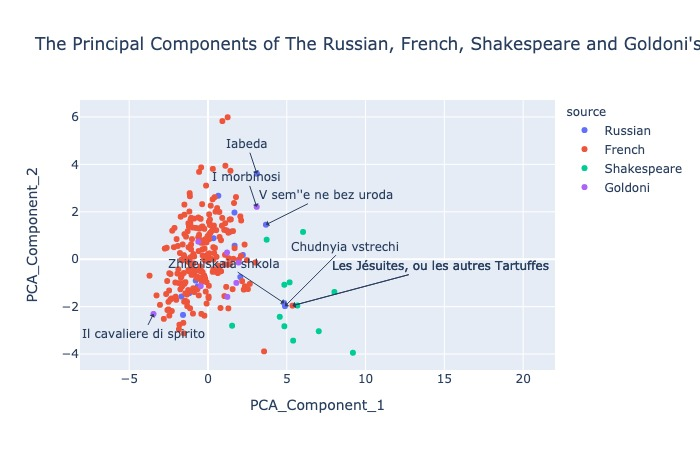

In [82]:
fig = px.scatter(combined_df, x='PCA_Component_1', y='PCA_Component_2',
               color='source', hover_data=['title'], 
                 title='The Principal Components of The Russian, French, Shakespeare and Goldoni\'s Comedies')

fig.add_annotation(x=combined_df[combined_df.title == 'I morbinosi']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'I morbinosi']['PCA_Component_2'].values[0],
            text='I morbinosi',
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=combined_df[combined_df.title == 'Iabeda']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'Iabeda']['PCA_Component_2'].values[0],
            text='Iabeda',
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=combined_df[combined_df.title == 'Chudnyia vstrechi']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'Chudnyia vstrechi']['PCA_Component_2'].values[0],
            text='Chudnyia vstrechi',
            showarrow=True,
            arrowhead=1,
            ax=60, 
            ay=-60)

fig.add_annotation(x=combined_df[combined_df.title == 'V sem\'\'e ne bez uroda']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'V sem\'\'e ne bez uroda']['PCA_Component_2'].values[0],
            text='V sem\'\'e ne bez uroda',
            showarrow=True,
            arrowhead=1, 
            ax=60, 
            ay=-30)

fig.add_annotation(x=combined_df[combined_df.title == 'Zhiteiiskaia shkola']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'Zhiteiiskaia shkola']['PCA_Component_2'].values[0],
            text='Zhiteiiskaia shkola',
            showarrow=True,
            arrowhead=1, 
            ax=-60, 
            ay=-40)

fig.add_annotation(x=combined_df[combined_df.title == 'Les Jésuites, ou les autres Tartuffes ']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'Les Jésuites, ou les autres Tartuffes ']['PCA_Component_2'].values[0],
            text='Les Jésuites, ou les autres Tartuffes ',
            showarrow=True,
            arrowhead=1, 
            ax=150, 
            ay=-40)

fig.add_annotation(x=combined_df[combined_df.title == 'Les Jésuites, ou les autres Tartuffes ']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'Les Jésuites, ou les autres Tartuffes ']['PCA_Component_2'].values[0],
            text='Les Jésuites, ou les autres Tartuffes ',
            showarrow=True,
            arrowhead=1, 
            ax=150, 
            ay=-40)

fig.add_annotation(x=combined_df[combined_df.title == 'Il cavaliere di spirito o sia La donna di testa debole']['PCA_Component_1'].values[0], 
                   y=combined_df[combined_df.title == 'Il cavaliere di spirito o sia La donna di testa debole']['PCA_Component_2'].values[0],
            text='Il cavaliere di spirito',
            showarrow=True,
            arrowhead=1, 
            ax=-10, 
            ay=20)

fig.show()

In [94]:
# save an interactive visualization on plotly's chart studio so that it can be rendered on github
import chart_studio
import chart_studio.plotly as py

with open('creds.json') as json_file:
    creds = json.load(json_file)

chart_studio.tools.set_credentials_file(username=creds['user_name'], api_key=creds['API_key'])

import chart_studio.plotly as py
py.plot(fig, filename = 'pca_visualization', auto_open=True)

In [104]:
# display the saved visualization
from IPython.display import IFrame
IFrame(src='https://chart-studio.plotly.com/~innafomina/3/#/', width=1000, height=600)

From the visualization of the two principal components, it is evident that Shakespeare's comedies form a separate cluster from the French tradition, mainly based on the first principal component that describes dramatic characters, their mobility, and non-utilization in dialogue. Based on the second principal component characterizing dramatic characters' speech, Shakespeare's comedies are far removed from the French comedies. 

The Russian five-act verse comedies mostly fit within the French cluster with a few notable exceptions: Vasilii	Kapnist's *Iabeda* (1794), Anonymous's *V sem''e ne bez uroda* (1813), Boris Fedorov's	*Chudnyia vstrechi* (1818), and Petr Grigor’ev's *Zhiteiiskaia shkola* (1849). The last two comedies appear within with "Shakespearean" cluster. 

Goldoni's comedies, for the most part, fit within the French tradition. Only two comedies maintain a distance (*I morbinosi* (1759) in the Venetian dialect) and *Il cavaliere di spirito* (1757).

The only French comedy within the "Shakespearean" cluster is Étienne Gosse's *Les Jésuites, ou les autres Tartuffes* (1827). This comedy had both the highest number of dramatic characters and the highest mobility coefficient for its period.

Shakespeare's two earlier comedies, *The Two Gentlemen of Verona* (1593) and *The Comedy of Errors* (1592) were the closest to the French cluster.

## Conclusions:
1. In two tentative periods, Russian comedies had higher mean values than the contemporaneous French. However, our principal component analysis and its visualization showed that most of the Russian five-act verse comedies (75%) fit within the French tradition. The remaining 25% of the Russian five-act comedies lie outside of the French cluster. These comedies include Vasilii Kapnist's *Iabeda* (1794), Anonymous's *V sem''e ne bez uroda* (1813), Boris Fedorov's *Chudnyia vstrechi* (1818), and Petr Grigor’ev's *Zhiteiiskaia shkola* (1849). 


2. Based on the first principal component characterizing dramatic characters, their movement, and non-utilization in dialogue, the French, and the Italian  (as represented by Goldoni) and most of the Russian (75%) traditions were very dissimilar from Shakespeare. Such features as the number of dramatic characters, their mobility, and the coefficient of unused dramatic characters most likely differentiated the continental, French-Italian tradition, which served as a model for most of the Russians, from the English tradition. The remaining 25% of the Russian five-act comedies, including a famous *Iabeda* (1794) maintained a distance from the French tradition. Two comedies, *Chudnyia vstrechi* (1818), and Petr Grigor’ev's *Zhiteiiskaia shkola* fit with the "Shakespearean" cluster. It will be insightful to repeat the process and investigate the place of the four-act verse comedies.


3. Based on the second principal component describing dramatic characters' speech, Shakespeare was far less "distant" from the continental tradition than based on the first principal component characterizing dramatic characters, their movement, and non-utilization in dialogue. In general, this principal component revealed more similarities between the continental and the English comic tradition - they appear to reflect a shared European taste.

## Part 2. Open-Form Scores

The open-form score measures how experimental a style of a particular tradition during a specified decade is. Generation of open-form scores is described in detail in the following notebook: https://github.com/innawendell/European_Comedy/blob/master/Analyses/Open_Form_Scores_Evolution.ipynb. In our current analysis, we will calculate open-form scores for each tradition (Russian five-act verse comedies, French five-act verse comedies as well as Shakespeare's and Goldoni's five-act comedies in verse) by decades. Finally, we will trace and compare the evolution of these traditions.

In [70]:
french_original_comedies['decades'] = french_original_comedies.date.apply(decade)

In [71]:
summary_french = scores_calculation(french_original_comedies, True)

In [72]:
russian_comedies_df = russian_comedies_df.rename(columns={'standard_range': 'sigma_iarkho'})
summary_russian = scores_calculation(russian_comedies_df, True, french_original_comedies)

In [73]:
goldoni_df = goldoni_df.rename(columns={'standard_range': 'sigma_iarkho', 'date': 'creation_date'})
shakespeare_df = shakespeare_df.rename(columns={'standard_range': 'sigma_iarkho', 'date': 'creation_date'})

In [74]:
goldoni_df['decades'] = goldoni_df.creation_date.apply(decade)
summary_goldoni = scores_calculation(goldoni_df , True, french_original_comedies)

In [75]:
shakespeare_df['decades'] = shakespeare_df.creation_date.apply(decade)
summary_shakespeare = scores_calculation(shakespeare_df , True, french_original_comedies)

### Open-Form Scores For Shakespeare

In [76]:
summary_shakespeare

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1600,5.01,3.52,0.03,-0.09,-0.52,1.59
1590,3.01,1.74,0.52,0.17,-0.60,0.97


### Open-Form Scores For Goldoni

In [77]:
summary_goldoni

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1750,0.12,1.18,-0.04,0.13,-0.13,0.25


### Open-Form Scores For Russian Five-Act Verse Comedies

In [78]:
summary_russian

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1810,1.12,0.73,1.31,0.91,0.17,0.85
1790,0.60,0.28,2.23,0.83,-0.03,0.78
1840,0.96,2.77,-0.21,-0.19,-0.05,0.66
1800,0.42,0.92,0.57,-1.06,-0.78,0.01
1780,0.25,0.64,-0.17,-0.18,-0.68,-0.03
1820,-0.64,1.24,1.01,-0.93,-1.13,-0.09
1770,-0.91,-0.24,-0.28,-1.54,-1.41,-0.88


### Open-Form Scores For French Five-Act Verse Comedies

In [79]:
summary_french

,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
decades,,,,,,
1830,2.20,0.98,0.57,0.13,-0.06,0.76
1650,0.31,-0.75,0.25,0.90,1.02,0.35
1680,0.96,0.08,-0.39,0.51,0.42,0.32
1670,0.45,0.09,0.10,0.43,0.50,0.31
1840,-0.02,0.90,0.42,-0.12,0.07,0.25
1660,-0.01,-0.50,0.30,0.46,0.68,0.19
1810,-0.19,0.28,0.30,0.38,-0.08,0.14
1790,0.05,0.50,0.18,-0.03,-0.30,0.08
1800,-0.14,0.49,0.05,0.04,-0.05,0.08


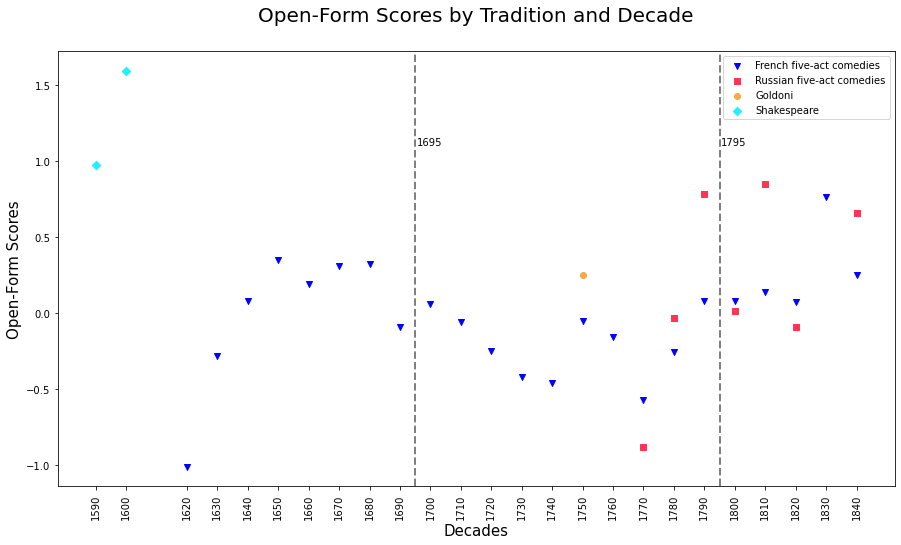

In [80]:
plt.figure(figsize=(15, 8))
plt.title('Open-Form Scores by Tradition and Decade', fontsize=20, pad=30)
plt.scatter(summary_french.index.tolist(), 
            summary_french['open_form_score'], 
            color='blue', 
            marker='v', 
            label='French five-act comedies')

plt.scatter(summary_russian.index.tolist(), 
            summary_russian['open_form_score'], 
            marker='s', 
            color='#FF3355', 
            label='Russian five-act comedies')


plt.scatter(summary_goldoni.index.tolist(), 
            summary_goldoni['open_form_score'], 
            marker="o", 
            color='#F7AA41', 
            label='Goldoni')

plt.scatter(summary_shakespeare.index.tolist(), 
            summary_shakespeare['open_form_score'], 
            marker="D", 
            color='#25EEFF', 
            label='Shakespeare')


plt.xticks(summary_french.index.tolist() + [1590, 1600], rotation=90)
plt.ylabel('Open-Form Scores', fontsize=15)
plt.xlabel('Decades', fontsize=15)
plt.axvline(1695, color='grey',linestyle='dashed', linewidth=2)
plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
plt.text(1695.5, 1.1, '1695')
plt.text(1795.5, 1.1, '1795')
plt.legend()
plt.show()

### Summary:
1. Shakespeare's five-act verse comedies were the most experimental in the examined material. Shakespeare's five-act verse comedies of the 1600s were more experimental (open-form score = 1.59) that his comedies of the 1590s (0.97).
2. Goldoni's comedies were more open that French comedies of the 1750s (open-form score for Goldoni = 0.25, French = -0.05).
3. The evolution of the open-form scores of the Russian five-act verse comedy revealed peculiar trends: 
    - In the 1770s, it was less experimental (open-form score = -0.88) than the French comedies of the same decade (open-form score = -0.57). In fact, the score was almost as low as the French comedy of 1620s (Pierre Corneille's *Mélite* with the open-form score = -1.01).
    - In the 1780s, the Russian comedies had a slightly higher open-form score than the contemporaneous French comedies.
    - In the 1790s, the Russian comedies had a much higher open-form score (0.78) than the contemporaneous French comedies (0.08).
    - In the 1800s, the Russian comedies had a very similar open-form score (0.01) to the French (0.08).
    - In the 1810s, the Russian comedies again had a much higher open-form score  (0.85) than the the contemporaneous French comedies (0.14).
    - In the 1820, the Russian comedies were even more closed (-0.09) than the French (0.07).
    - In the 1840s, the Russian comedies were more open (0.66) than the French (0.25).
   

### Conclusions:
1. The evolution curve of the French five-act comedies in verse had a wave-like shape with alternating open and closed forms.
2. The periods of most openness in the French comedy included
    - the Molièrean period (1650 to 1680), which was very far from the openness of Shakespeare;
    - the late Romantic period (1830 - 1840), the first half of which (the 1830s) almost approached the openness of Shakespeare of the 1590s and exceeded the openness the Molièrean period. The second half (the 1840s), did not reach the openness of the Molièrean period and also below the contemporaneous Russian comedies of the time.
    - the 1750s - 1760s revealed an increase in openness. This question requires further investigation.
2. The Russian evolution did not have a wave-shaped curve: since the 1790s, the open and closed forms co-existed (the appearing alternation of the open and closed forms between decades on the graph is simply the result of grouping by decades. In reality, if we were to examine each individual comedy, we would find both closed and open forms co-existing).
3. The French tradition could have been influential for the Russian five-act comedies in verse of the 1770s, 1780s, 1800s, and 1820s. During the 1790s, 1810s, and 1840s, the Russian five-act comedies in verse tended to be more experimental and potentially influenced by another tradition. 
3. Based on the principal component characterizing dramatic characters, their movements, and non-utilization in dialogue, most of the Russian five-act verse comedies (75%) clustered with the French tradition. The remaining 25%, Vasilii Kapnist's Iabeda (1794), Anonymous's V sem''e ne bez uroda (1813), Boris Fedorov's Chudnyia vstrechi (1818), and Petr Grigor’ev's Zhiteiiskaia shkola (1849), maintained a distance from the French tradition. These comedies could explain why the 1790s, 1810s, and 1840s were more experimental. Based on this principal component, the last two comedies even approached Shakespeare.
4. Shakespeare's five-act verse comedies were the most experimental in form out of all five-act verse comedies we analyzed. This is particularly true of the features describing dramatic characters, their movements, and non-utilization in dialogue. Based on principal component describing dramatic characters' speech, Shakespeare was not as distant from the continental French-Italian comic tradition.
5. Based on the analysis of the mean values of the features, Goldoni's five-act comedies were more experimental than the contemporaneous French five-act comedies in verse. They were close in style to the French comedies of the 1660s and 1840s. The principal component analysis and its visualization revealed that Goldoni, for the most part, fit within the continental comic tradition.